#패키지 불러오기

In [1]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input, Conv2DTranspose, MaxPooling2D, concatenate
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import numpy as np
import os
import re
tf.random.set_seed(15)

# 파일 로딩

In [2]:
!git clone git://github.com/chaeb/Reconstruct-Masked-Face-ver2.git

Cloning into 'Reconstruct-Masked-Face-ver2'...
remote: Enumerating objects: 8009, done.
remote: Total 8009 (delta 0), reused 0 (delta 0), pack-reused 8009
Receiving objects: 100% (8009/8009), 137.62 MiB | 42.51 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (8003/8003), done.


# 이미지 파일 전처리

## 함수 정의

In [3]:
def plot_image_pair_val(val_predict, start, end):
    for i in range(start, end):
        plt.figure(figsize = (7,7))
        plt.xticks(color='w')
        plt.yticks(color='w')
        plt.subplot(1,3,1)
        plt.imshow(val_mask_image[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,3,2)
        plt.imshow(val_image[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,3,3)
        plt.imshow(val_predict[i].reshape(SIZE,SIZE,3))      

In [4]:
def plot_image_pair_test(test_predict, start, end):
    for i in range(start, end):
        plt.figure(figsize = (7,7))
        plt.xticks(color='w')
        plt.yticks(color='w')
        plt.subplot(1,3,1)
        plt.imshow(test_mask_image[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,3,2)
        plt.imshow(test_image[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,3,3)
        plt.imshow(test_predict[i].reshape(SIZE,SIZE,3))

## 전처리 함수 정의

In [5]:
def preProcessImage(img):
  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # 흰색 
  lower_1 = np.array([200,200,200])
  upper_1 = np.array([255, 255, 255])

  #밝은 하늘색
  lower_2 = np.array([130,190,210])
  upper_2 = np.array([160, 255, 255])
  
  #진한 네이비색
  lower_3 = np.array([60,120,130])
  upper_3 = np.array([100,168,200])

  lower_4 = np.array([0,0,0])
  upper_4 = np.array([0,0,0])

  #제외할 색상영역

  lower_not = np.array([0,0,0])
  upper_not = np.array([0,0,0])


  #각 조건에 따라 선택된 영역들
  red_select_1 = cv2.inRange(rgb,lower_1,upper_1)
  red_select_2 = cv2.inRange(rgb,lower_2,upper_2)
  red_select_3 = cv2.inRange(rgb,lower_3,upper_3)
  red_select_4 = cv2.inRange(rgb,lower_4,upper_4)
  red_select_not = cv2.inRange(rgb, lower_not, upper_not)
  red_exclude = cv2.bitwise_not(red_select_not)

  #조건들 순차적으로 합쳐주기
  red_select_aug_1 = cv2.bitwise_or(red_select_1, red_select_2)
  red_select_aug_2 = cv2.bitwise_or(red_select_aug_1, red_select_3) 
  red_select_aug_3 = cv2.bitwise_or(red_select_aug_2, red_select_4) 
  red_select_aug_4 = cv2.bitwise_and(red_select_aug_3, red_exclude)

  #red_select_aug_4 = cv2.bitwise_not(red_select_aug_4)
  kernel = np.ones((7,7))
  red_select_aug_4 = cv2.dilate(red_select_aug_4, kernel, iterations = 1)
  contours, hierarchy = cv2.findContours(red_select_aug_4, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  
  #윤곽선 중 면적 2000 이상인 윤곽선 내부만 살려서 원본 이미지에 검게 칠하기
  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 2000:
        #cv2.drawContours(original, cnt, -1, (255, 0 ,255), 3)
        cv2.drawContours(img ,[cnt], 0, (0,0,0), -1)

## 전처리(image load + img_to_array)

In [6]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of image 
SIZE = 128

mask_path = '/content/Reconstruct-Masked-Face-ver2/mask_train'
mask_array = []

mask_val_path = '/content/Reconstruct-Masked-Face-ver2/mask_val'
mask_val_array = []

mask_test_path = '/content/Reconstruct-Masked-Face-ver2/mask_test'
mask_test_array = []

image_path = '/content/Reconstruct-Masked-Face-ver2/no_mask_train'
img_array = []

image_val_path = '/content/Reconstruct-Masked-Face-ver2/no_mask_val'
img_val_array = []

image_test_path = '/content/Reconstruct-Masked-Face-ver2/no_mask_test'
img_test_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
mask_file = sorted_alphanumeric(os.listdir(mask_path))
image_file.remove('.DS_Store')

image_val_file = sorted_alphanumeric(os.listdir(image_val_path))
mask_val_file = sorted_alphanumeric(os.listdir(mask_val_path))
image_val_file.remove('.DS_Store')

image_test_file = sorted_alphanumeric(os.listdir(image_test_path))
mask_test_file = sorted_alphanumeric(os.listdir(mask_test_path))
image_test_file.remove('.DS_Store')

#mask_train
for i in tqdm(mask_file):
    
    if i == '':
        break
    else:    
        image = cv2.imread(mask_path + '/' + i,1)

        preProcessImage(image)

        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
        
        # normalizing image 
        image = image.astype('float32') / 255.0

        #appending normal normal image
        mask_array.append(img_to_array(image))
        
#mask_val
for i in tqdm(mask_val_file):
    
    if i == '':
        break
    else:    
        image = cv2.imread(mask_val_path + '/' + i,1)

        preProcessImage(image)

        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
        
        # normalizing image 
        image = image.astype('float32') / 255.0

        #appending normal normal image    
        mask_val_array.append(img_to_array(image)) 
        
#mask_test
for i in tqdm(mask_test_file):
   
    if i == '':
        break
    else:    
        image = cv2.imread(mask_test_path + '/' + i,1)

        preProcessImage(image)

        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
        
        # normalizing image 
        image = image.astype('float32') / 255.0

        #appending normal normal image    
        mask_test_array.append(img_to_array(image)) 
        
#no_mask_train    
for i in tqdm(image_file):
 
    if i == '':
        break
    
    else:
        image = cv2.imread(image_path + '/' + i,1)

       
        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
       
        # normalizing image 
        image = image.astype('float32') / 255.0
        # appending normal sketch image
        img_array.append(img_to_array(image))
        
#no_mask_val
for i in tqdm(image_val_file):
 
    if i == '':
        break
    
    else:
        image = cv2.imread(image_val_path + '/' + i,1)
      
        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))
        
        # normalizing image 
        image = image.astype('float32') / 255.0
        # appending normal sketch image
        img_val_array.append(img_to_array(image))

#no_mask_test
for i in tqdm(image_test_file):
 
    if i == '':
        break
    
    else:
        image = cv2.imread(image_test_path + '/' + i,1)
        
        # as opencv load image in bgr format converting it to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing images 
        image = cv2.resize(image, (SIZE, SIZE))

        # normalizing image 
        image = image.astype('float32') / 255.0
        # appending normal sketch image
        img_test_array.append(img_to_array(image))

100%|██████████| 500/500 [00:00<00:00, 790.41it/s]


## 전처리된 이미지 확인

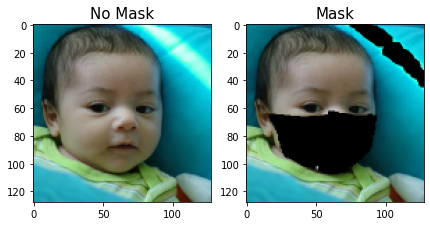

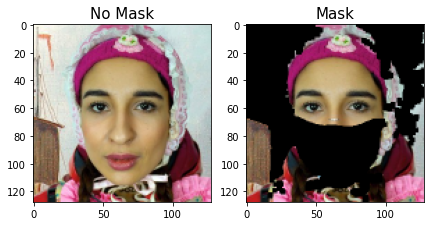

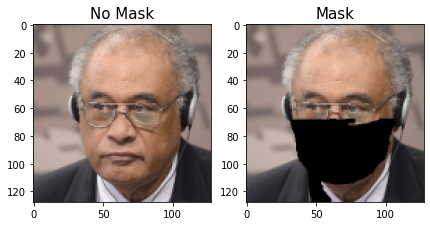

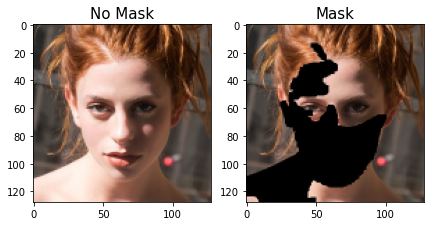

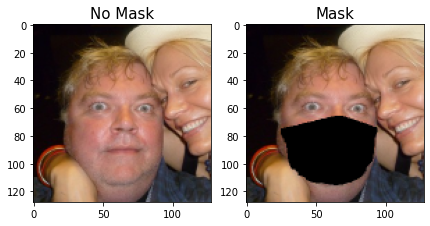

In [7]:
def plot_image_pair(images = 5):
    for i in range(images):
        plt.figure(figsize = (7,7))
        plt.subplot(1,2,1)
        plt.title("No Mask", fontsize = 15)
        plt.imshow(img_array[i].reshape(SIZE, SIZE, 3))
        plt.subplot(1,2,2)
        plt.title("Mask", fontsize = 15)
        plt.imshow(mask_array[i].reshape(SIZE, SIZE, 3))
        
        
        
plot_image_pair(5)

# train - val - test 나누기

In [8]:
train_mask_image = mask_array
train_image = img_array
val_mask_image = mask_val_array
val_image = img_val_array
test_mask_image = mask_test_array
test_image = img_test_array
# reshaping
train_mask_image = np.reshape(train_mask_image,(len(train_mask_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train no mask image shape:',train_image.shape)
val_mask_image = np.reshape(val_mask_image,(len(val_mask_image),SIZE,SIZE,3))
val_image = np.reshape(val_image, (len(val_image),SIZE,SIZE,3))
print('Validation no mask image shape',val_image.shape)
test_mask_image = np.reshape(test_mask_image,(len(test_mask_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test no mask image shape',test_image.shape)

Train no mask image shape: (3000, 128, 128, 3)
Validation no mask image shape (500, 128, 128, 3)
Test no mask image shape (500, 128, 128, 3)


# Data Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,                    # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,                      # randomly zoom image 
    fill_mode='nearest',
    width_shift_range=0.005,                # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.005)              # randomly shift images vertically (fraction of total height)

In [12]:
datagen.fit(train_mask_image)
datagen.fit(train_image)

datagen.fit(val_mask_image)
datagen.fit(val_image)

datagen.fit(test_mask_image)
datagen.fit(test_image)

# AutoEncoder layer쌓기(Unet)

## Unet layer

In [13]:
inputs = Input((SIZE, SIZE, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

# final model
model6_3_1 = keras.Model(inputs=[inputs], outputs=[conv10])
model6_3_2 = keras.Model(inputs=[inputs], outputs=[conv10])
model6_3_3 = keras.Model(inputs=[inputs], outputs=[conv10])
model6_3_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## 모델 그리기(Unet)

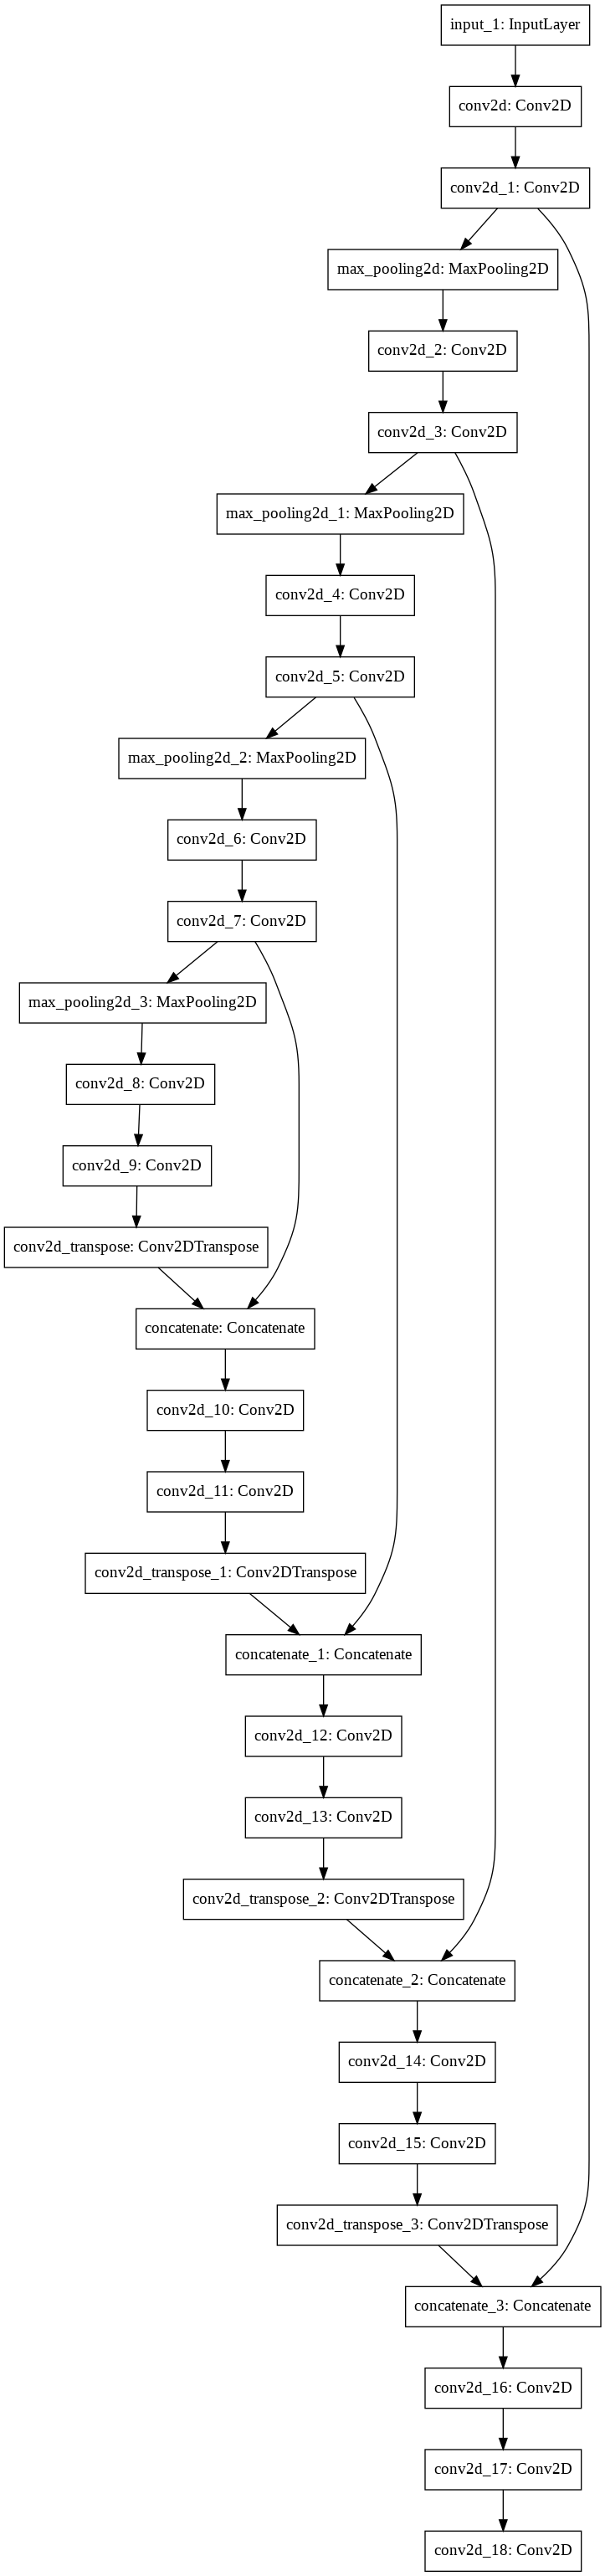

In [14]:
from keras.utils import plot_model
plot_model(model6_3_1)

## ImageDenoising layer </br>(https://github.com/nsarang/ImageDenoisingAutoencdoer/blob/master/DenoisingAutoencoder.ipynb)

In [18]:
encoder_input = keras.Input(shape=(SIZE,SIZE, 3), name="img")

conv1 = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(encoder_input)
conv1 = tf.keras.layers.LeakyReLU()(conv1)
conv1 = tf.keras.layers.Dropout(0.2)(conv1)
conv1 = tf.keras.layers.BatchNormalization()(conv1)

conv2 = Conv2D(filters = 64,kernel_size = (3,3), strides = 2, padding = 'same')(conv1)
conv2 = tf.keras.layers.LeakyReLU()(conv2)
conv2 = tf.keras.layers.Dropout(0.2)(conv2)
conv2 = tf.keras.layers.BatchNormalization()(conv2)

conv3 = Conv2D(filters = 128,kernel_size = (5,5), strides = 2, padding = 'same')(conv2)
conv3 = tf.keras.layers.LeakyReLU()(conv3)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.BatchNormalization()(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same')(conv3)
conv4 = tf.keras.layers.LeakyReLU()(conv4)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.BatchNormalization()(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (5,5), strides = 2, padding = 'same')(conv4)
conv5 = tf.keras.layers.LeakyReLU()(conv5)
conv5 = tf.keras.layers.Dropout(0.2)(conv5)
conv5 = tf.keras.layers.BatchNormalization()(conv5)

encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), strides = 2, padding = 'same')(conv5) 
encoder = tf.keras.Model(encoder_input, encoder_output)



decoder_input = Conv2DTranspose(filters = 512 ,kernel_size = (3,3), strides = 2, padding = 'same')(encoder_output)

skip1 = tf.keras.layers.concatenate([decoder_input, conv5])
conv7 = Conv2D(256, 3, strides=1, padding='same')(skip1)
conv7 = tf.keras.layers.LeakyReLU()(conv7)
conv7 = tf.keras.layers.Dropout(0.2)(conv7)
conv7 = tf.keras.layers.BatchNormalization()(conv7)
deconv2 = Conv2DTranspose(128, 3, strides=2, padding='same')(conv7)
deconv2 = tf.keras.layers.LeakyReLU()(deconv2)
deconv2 = tf.keras.layers.Dropout(0.2)(deconv2)
deconv2 = tf.keras.layers.BatchNormalization()(deconv2)

skip2 = tf.keras.layers.concatenate([deconv2, conv3])
conv8 = Conv2D(128, 5, strides=1, padding='same')(skip2)
conv8 = tf.keras.layers.LeakyReLU()(conv8)
conv8 = tf.keras.layers.Dropout(0.2)(conv8)
conv8 = tf.keras.layers.BatchNormalization()(conv8)
deconv3 = Conv2DTranspose(64, 3, strides=2, padding='same')(conv8)
deconv3 = tf.keras.layers.LeakyReLU()(deconv3)
deconv3 = tf.keras.layers.Dropout(0.2)(deconv3)
deconv3 = tf.keras.layers.BatchNormalization()(deconv3)

skip3 = tf.keras.layers.concatenate([deconv3, conv2])
conv9 = Conv2D(64, 5, strides=1, padding='same')(skip3)
conv9 = tf.keras.layers.LeakyReLU()(conv9)
conv9 = tf.keras.layers.Dropout(0.2)(conv9)
conv9 = tf.keras.layers.BatchNormalization()(conv9)
deconv4 = Conv2DTranspose(64, 3, strides=2, padding='same')(conv9)
deconv4 = tf.keras.layers.LeakyReLU()(deconv4)
deconv4 = tf.keras.layers.Dropout(0.2)(deconv4)
deconv4 = tf.keras.layers.BatchNormalization()(deconv4)

skip4 = tf.keras.layers.concatenate([deconv4, conv1])
decoder_output = Conv2D(3, 3, strides=1, padding='same', activation='sigmoid', kernel_initializer='orthogonal')(skip4)

# final model
model6_5_1 = keras.Model(encoder_input, decoder_output)
model6_5_2 = keras.Model(encoder_input, decoder_output)
model6_5_3 = keras.Model(encoder_input, decoder_output)
model6_5_1.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 128, 128, 64) 1792        img[0][0]                        
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 128, 128, 64) 0           leaky_re_lu_11[0][0]             
____________________________________________________________________________________________

## 모델 그리기(ImageDenoising)

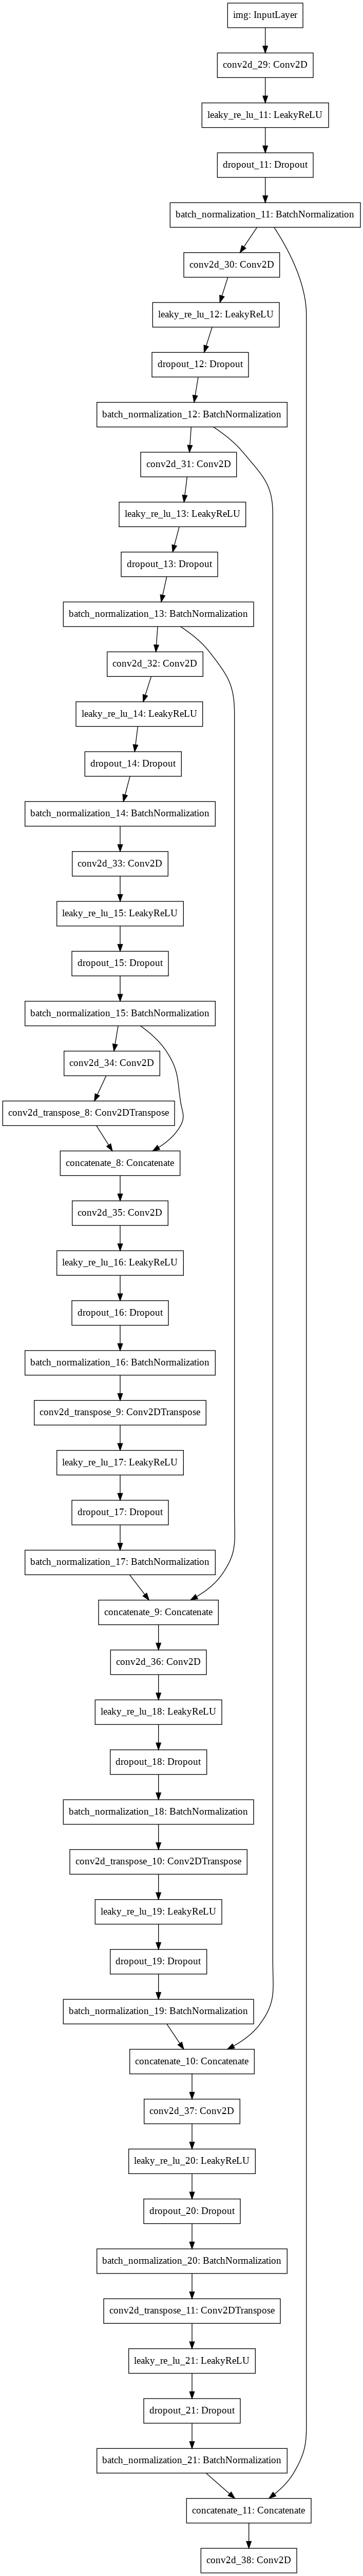

In [19]:
from keras.utils import plot_model
plot_model(model6_5_1)

# SSIM metrics 정의

In [20]:
def SSIM(reconstructed, truth):
    return tf.image.ssim(reconstructed, truth, 1.0)

# model compile 및 fit

## model6_3_1(Unet): SGD(learning_rate=0.01), batch size=32, epoch= 100

In [21]:
model6_3_1.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01), loss = 'mean_squared_error', 
              metrics = [SSIM])
history6_3_1 = model6_3_1.fit(train_mask_image, train_image, epochs = 100, batch_size=32, validation_data=(val_mask_image, val_image))

Epoch 1/100
94/94 [==============================] - 57s 213ms/step - loss: 0.0653 - SSIM: 0.3172 - val_loss: 0.0629 - val_SSIM: 0.3226
Epoch 2/100
94/94 [==============================] - 15s 162ms/step - loss: 0.0632 - SSIM: 0.3209 - val_loss: 0.0619 - val_SSIM: 0.3239
Epoch 3/100
94/94 [==============================] - 15s 165ms/step - loss: 0.0626 - SSIM: 0.3215 - val_loss: 0.0610 - val_SSIM: 0.3254
Epoch 4/100
94/94 [==============================] - 15s 165ms/step - loss: 0.0620 - SSIM: 0.3197 - val_loss: 0.0602 - val_SSIM: 0.3271
Epoch 5/100
94/94 [==============================] - 15s 162ms/step - loss: 0.0620 - SSIM: 0.3202 - val_loss: 0.0595 - val_SSIM: 0.3291
Epoch 6/100
94/94 [==============================] - 15s 161ms/step - loss: 0.0596 - SSIM: 0.3268 - val_loss: 0.0588 - val_SSIM: 0.3315
Epoch 7/100
94/94 [==============================] - 15s 161ms/step - loss: 0.0594 - SSIM: 0.3259 - val_loss: 0.0581 - val_SSIM: 0.3344
Epoch 8/100
94/94 [=============================

In [22]:
#모델 저장
model6_3_1.save('/content/6_3_1.h5', overwrite=True, include_optimizer=True)
#로컬로 다운로드
from google.colab import files
files.download('6_3_1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## model6_3_2(Unet): Adam(learning_rate=0.001), batch size=32, epoch= 100

In [38]:
model6_3_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error', 
              metrics = [SSIM])
history6_3_2 = model6_3_2.fit(train_mask_image, train_image, epochs = 100, batch_size=32, validation_data=(val_mask_image, val_image))

Epoch 1/100
94/94 [==============================] - 17s 169ms/step - loss: 0.0492 - SSIM: 0.5488 - val_loss: 0.0130 - val_SSIM: 0.6766
Epoch 2/100
94/94 [==============================] - 15s 164ms/step - loss: 0.0123 - SSIM: 0.6908 - val_loss: 0.0118 - val_SSIM: 0.7212
Epoch 3/100
94/94 [==============================] - 15s 161ms/step - loss: 0.0097 - SSIM: 0.7281 - val_loss: 0.0077 - val_SSIM: 0.7461
Epoch 4/100
94/94 [==============================] - 15s 158ms/step - loss: 0.0073 - SSIM: 0.7488 - val_loss: 0.0065 - val_SSIM: 0.7583
Epoch 5/100
94/94 [==============================] - 15s 158ms/step - loss: 0.0064 - SSIM: 0.7632 - val_loss: 0.0058 - val_SSIM: 0.7715
Epoch 6/100
94/94 [==============================] - 15s 159ms/step - loss: 0.0054 - SSIM: 0.7778 - val_loss: 0.0054 - val_SSIM: 0.7802
Epoch 7/100
94/94 [==============================] - 15s 160ms/step - loss: 0.0050 - SSIM: 0.7865 - val_loss: 0.0054 - val_SSIM: 0.7856
Epoch 8/100
94/94 [=============================

In [39]:
#모델 저장
model6_3_2.save('/content/6_3_2.h5', overwrite=True, include_optimizer=True)
#로컬로 다운로드
from google.colab import files
files.download('6_3_2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## model6_3_3(Unet): RMSprop(learning_rate=0.001), batch size=32, epoch= 100

In [41]:
model6_3_3.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001), loss = 'mean_squared_error', 
              metrics = [SSIM])
history6_3_3 = model6_3_3.fit(train_mask_image, train_image, epochs = 100, batch_size=32, validation_data=(val_mask_image, val_image))

Epoch 1/100
94/94 [==============================] - 18s 168ms/step - loss: 0.0204 - SSIM: 0.7747 - val_loss: 0.0066 - val_SSIM: 0.8343
Epoch 2/100
94/94 [==============================] - 16s 167ms/step - loss: 0.0045 - SSIM: 0.8825 - val_loss: 0.0062 - val_SSIM: 0.8590
Epoch 3/100
94/94 [==============================] - 15s 165ms/step - loss: 0.0037 - SSIM: 0.8906 - val_loss: 0.0043 - val_SSIM: 0.8677
Epoch 4/100
94/94 [==============================] - 15s 163ms/step - loss: 0.0034 - SSIM: 0.8934 - val_loss: 0.0039 - val_SSIM: 0.8778
Epoch 5/100
94/94 [==============================] - 15s 162ms/step - loss: 0.0030 - SSIM: 0.9004 - val_loss: 0.0051 - val_SSIM: 0.8704
Epoch 6/100
94/94 [==============================] - 15s 162ms/step - loss: 0.0030 - SSIM: 0.9011 - val_loss: 0.0060 - val_SSIM: 0.8614
Epoch 7/100
94/94 [==============================] - 15s 163ms/step - loss: 0.0027 - SSIM: 0.9026 - val_loss: 0.0040 - val_SSIM: 0.8776
Epoch 8/100
94/94 [=============================

In [42]:
#모델 저장
model6_3_3.save('/content/6_3_3.h5', overwrite=True, include_optimizer=True)

#로컬로 다운로드
from google.colab import files
files.download('6_3_3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## model6_5_1(imageDenoise): SGD(learning_rate=0.01), batch size=32, epoch= 100

In [43]:
model6_5_1.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01), loss = 'mean_squared_error', 
              metrics = [SSIM])
history6_5_1 = model6_5_1.fit(train_mask_image, train_image, epochs = 100, batch_size=32, validation_data=(val_mask_image, val_image))

Epoch 1/100
94/94 [==============================] - 33s 303ms/step - loss: 0.0920 - SSIM: 0.0441 - val_loss: 0.0622 - val_SSIM: 0.3212
Epoch 2/100
94/94 [==============================] - 24s 259ms/step - loss: 0.0704 - SSIM: 0.0842 - val_loss: 0.0578 - val_SSIM: 0.2862
Epoch 3/100
94/94 [==============================] - 24s 259ms/step - loss: 0.0598 - SSIM: 0.1031 - val_loss: 0.0550 - val_SSIM: 0.2712
Epoch 4/100
94/94 [==============================] - 24s 259ms/step - loss: 0.0521 - SSIM: 0.1231 - val_loss: 0.0529 - val_SSIM: 0.2995
Epoch 5/100
94/94 [==============================] - 24s 259ms/step - loss: 0.0466 - SSIM: 0.1442 - val_loss: 0.0473 - val_SSIM: 0.3504
Epoch 6/100
94/94 [==============================] - 24s 259ms/step - loss: 0.0415 - SSIM: 0.1615 - val_loss: 0.0395 - val_SSIM: 0.3932
Epoch 7/100
94/94 [==============================] - 24s 259ms/step - loss: 0.0394 - SSIM: 0.1758 - val_loss: 0.0327 - val_SSIM: 0.4195
Epoch 8/100
94/94 [=============================

In [44]:
#모델 저장
model6_5_1.save('/content/6_5_1.h5', overwrite=True, include_optimizer=True)

#로컬로 다운로드
from google.colab import files
files.download('6_5_1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## model6_5_2(imageDenoise): Adam(learning_rate=0.001), batch size=32, epoch= 100

In [45]:
model6_5_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error', 
              metrics = [SSIM])
history6_5_2 = model6_5_2.fit(train_mask_image, train_image, epochs = 100, batch_size=32, validation_data=(val_mask_image, val_image))

Epoch 1/100
94/94 [==============================] - 27s 264ms/step - loss: 0.0198 - SSIM: 0.4844 - val_loss: 0.0972 - val_SSIM: 0.4524
Epoch 2/100
94/94 [==============================] - 24s 260ms/step - loss: 0.0113 - SSIM: 0.5674 - val_loss: 0.0695 - val_SSIM: 0.6088
Epoch 3/100
94/94 [==============================] - 24s 260ms/step - loss: 0.0089 - SSIM: 0.6104 - val_loss: 0.0849 - val_SSIM: 0.6239
Epoch 4/100
94/94 [==============================] - 24s 260ms/step - loss: 0.0082 - SSIM: 0.6473 - val_loss: 0.0690 - val_SSIM: 0.6537
Epoch 5/100
94/94 [==============================] - 24s 260ms/step - loss: 0.0077 - SSIM: 0.6768 - val_loss: 0.0832 - val_SSIM: 0.6392
Epoch 6/100
94/94 [==============================] - 24s 260ms/step - loss: 0.0066 - SSIM: 0.7011 - val_loss: 0.0644 - val_SSIM: 0.6570
Epoch 7/100
94/94 [==============================] - 24s 260ms/step - loss: 0.0070 - SSIM: 0.7091 - val_loss: 0.0225 - val_SSIM: 0.7487
Epoch 8/100
94/94 [=============================

In [46]:
#모델 저장
model6_5_2.save('/content/6_5_2.h5', overwrite=True, include_optimizer=True)
#로컬로 다운로드
from google.colab import files
files.download('6_5_2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## model6_5_3(imageDenoise): RMSprop(learning_rate=0.001), batch size=32, epoch= 100

In [49]:
model6_5_3.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001), loss = 'mean_squared_error', 
              metrics = [SSIM])
history6_5_3 = model6_5_3.fit(train_mask_image, train_image, epochs = 100, batch_size=32, validation_data=(val_mask_image, val_image))

Epoch 1/100
94/94 [==============================] - 28s 266ms/step - loss: 0.0043 - SSIM: 0.8087 - val_loss: 0.0037 - val_SSIM: 0.8673
Epoch 2/100
94/94 [==============================] - 25s 266ms/step - loss: 0.0036 - SSIM: 0.8170 - val_loss: 0.0044 - val_SSIM: 0.8683
Epoch 3/100
94/94 [==============================] - 25s 262ms/step - loss: 0.0034 - SSIM: 0.8173 - val_loss: 0.0173 - val_SSIM: 0.8391
Epoch 4/100
94/94 [==============================] - 25s 261ms/step - loss: 0.0038 - SSIM: 0.8131 - val_loss: 0.0049 - val_SSIM: 0.8623
Epoch 5/100
94/94 [==============================] - 25s 262ms/step - loss: 0.0036 - SSIM: 0.8160 - val_loss: 0.0038 - val_SSIM: 0.8702
Epoch 6/100
94/94 [==============================] - 25s 263ms/step - loss: 0.0033 - SSIM: 0.8208 - val_loss: 0.0060 - val_SSIM: 0.8460
Epoch 7/100
94/94 [==============================] - 25s 263ms/step - loss: 0.0037 - SSIM: 0.8167 - val_loss: 0.0151 - val_SSIM: 0.8406
Epoch 8/100
94/94 [=============================

In [50]:
#모델 저장
model6_5_3.save('/content/6_5_3.h5', overwrite=True, include_optimizer=True)

#로컬로 다운로드
from google.colab import files
files.download('6_5_3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 모델별 train/val loss & metrics 그래프

## model6_3_1(Unet): SGD(learning_rate=0.01), batch size=32, epoch= 100


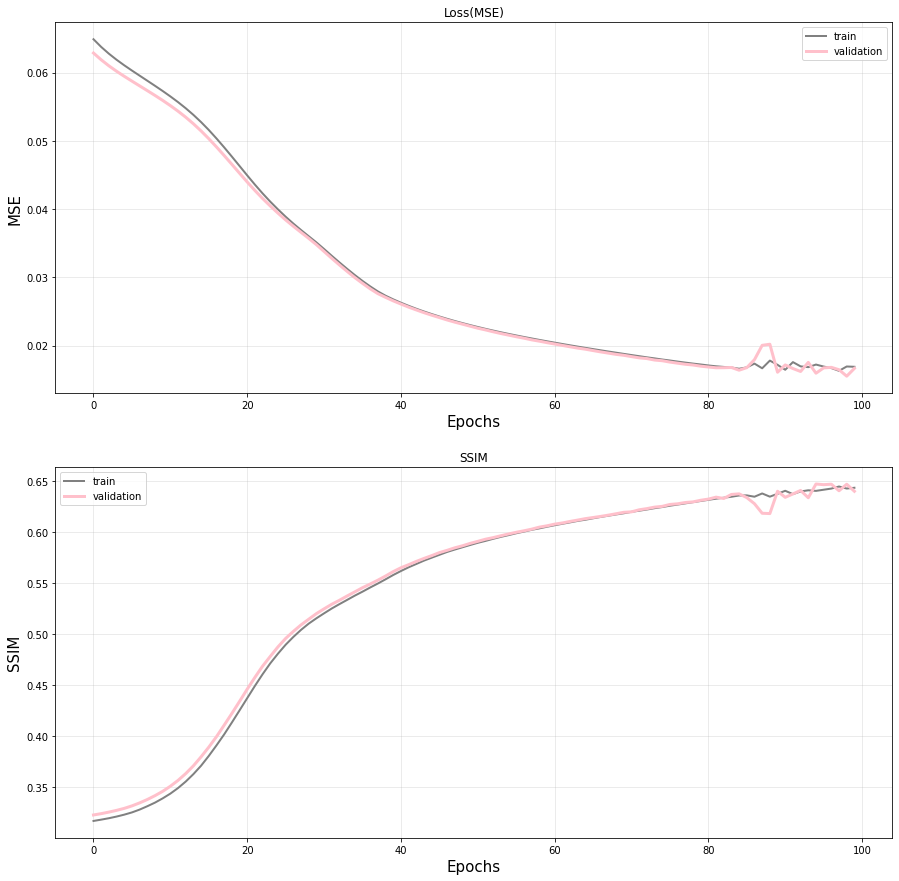

In [51]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history6_3_1.epoch, history6_3_1.history['loss'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_3_1.epoch, history6_3_1.history['val_loss'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('Loss(MSE)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(2,1,2)
plt.plot(history6_3_1.epoch, history6_3_1.history['SSIM'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_3_1.epoch, history6_3_1.history['val_SSIM'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('SSIM')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.grid(alpha=0.3)

plt.legend()

## model6_3_2(Unet): Adam(learning_rate=0.001), batch size=32, epoch= 100


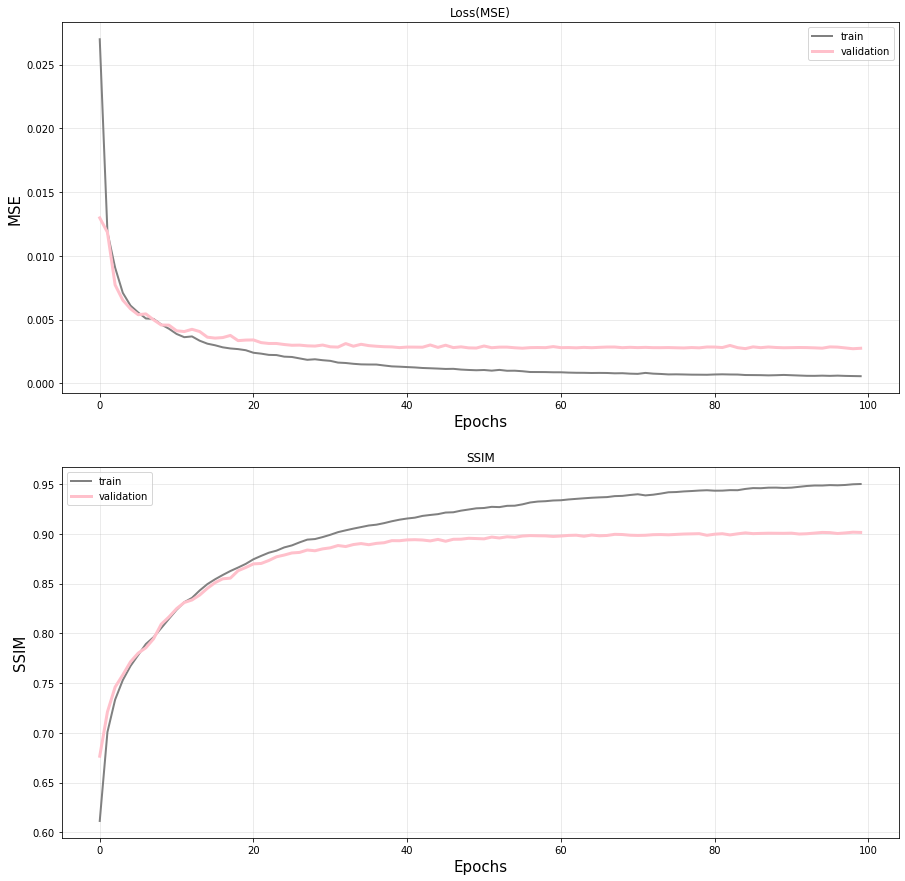

In [52]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history6_3_2.epoch, history6_3_2.history['loss'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_3_2.epoch, history6_3_2.history['val_loss'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('Loss(MSE)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(2,1,2)
plt.plot(history6_3_2.epoch, history6_3_2.history['SSIM'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_3_2.epoch, history6_3_2.history['val_SSIM'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('SSIM')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.grid(alpha=0.3)

plt.legend()

## model6_3_3(Unet): RMSprop(learning_rate=0.001), batch size=32, epoch= 100


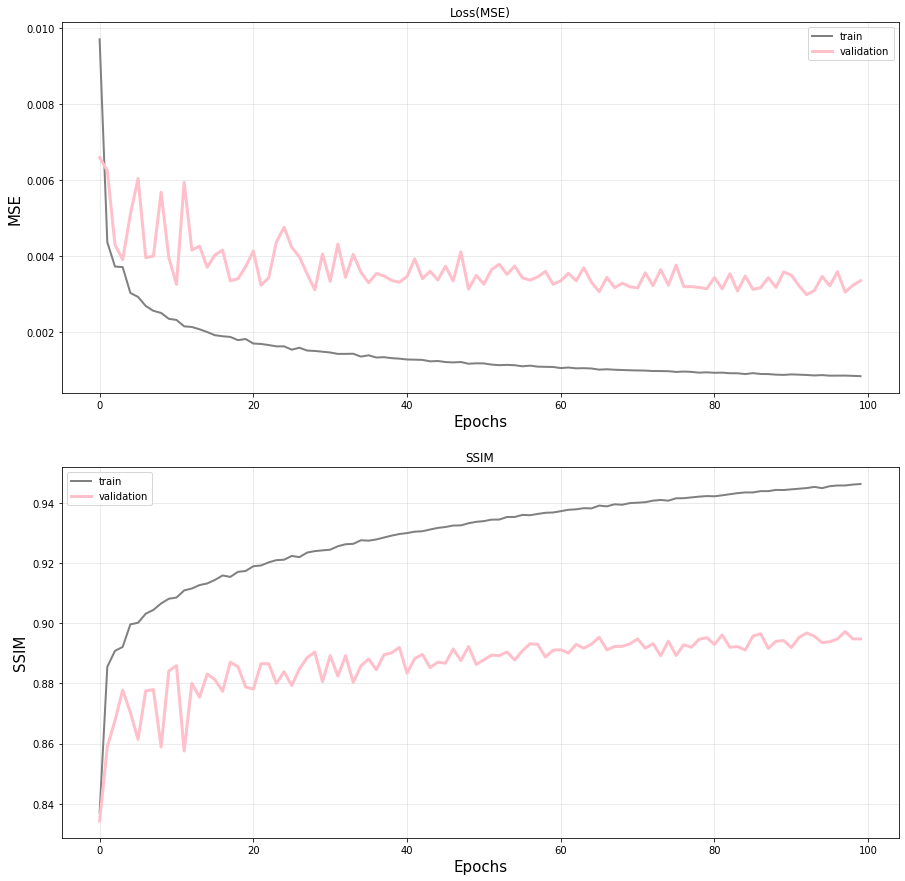

In [53]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history6_3_3.epoch, history6_3_3.history['loss'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_3_3.epoch, history6_3_3.history['val_loss'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('Loss(MSE)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(2,1,2)
plt.plot(history6_3_3.epoch, history6_3_3.history['SSIM'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_3_3.epoch, history6_3_3.history['val_SSIM'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('SSIM')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.grid(alpha=0.3)

plt.legend()

## model6_5_1(imageDenoise): SGD(learning_rate=0.01), batch size=32, epoch= 100



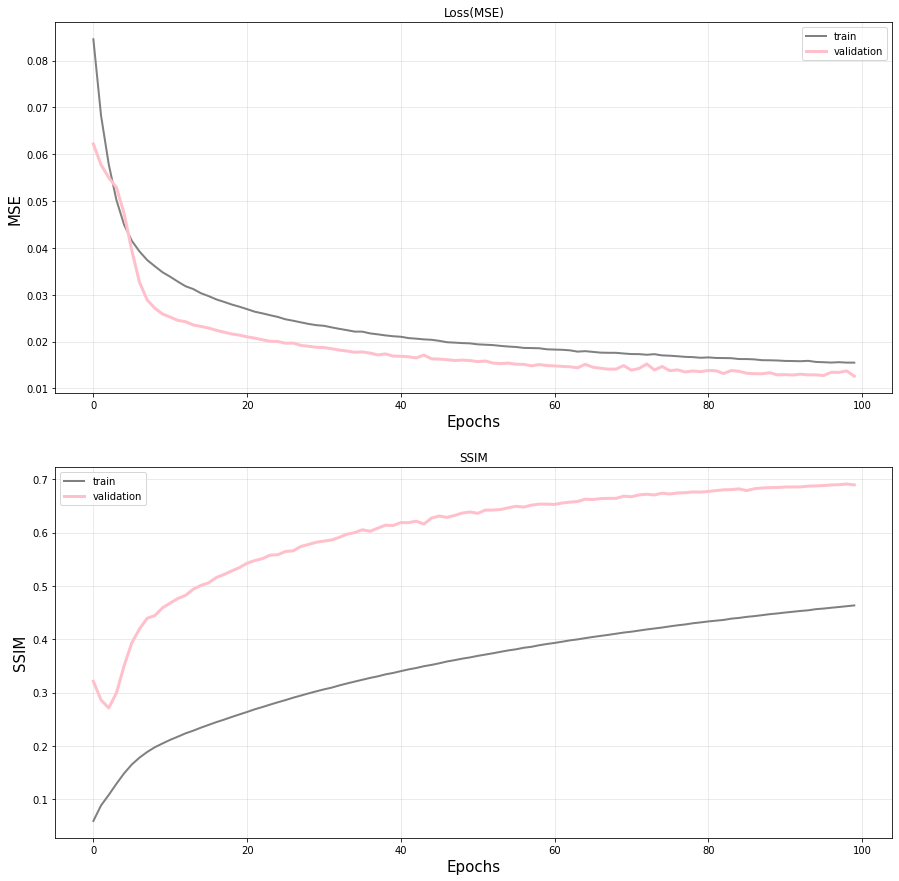

In [54]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history6_5_1.epoch, history6_5_1.history['loss'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_5_1.epoch, history6_5_1.history['val_loss'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('Loss(MSE)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(2,1,2)
plt.plot(history6_5_1.epoch, history6_5_1.history['SSIM'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_5_1.epoch, history6_5_1.history['val_SSIM'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('SSIM')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.grid(alpha=0.3)

plt.legend()

## model6_5_2(imageDenoise): Adam(learning_rate=0.001), batch size=32, epoch= 100


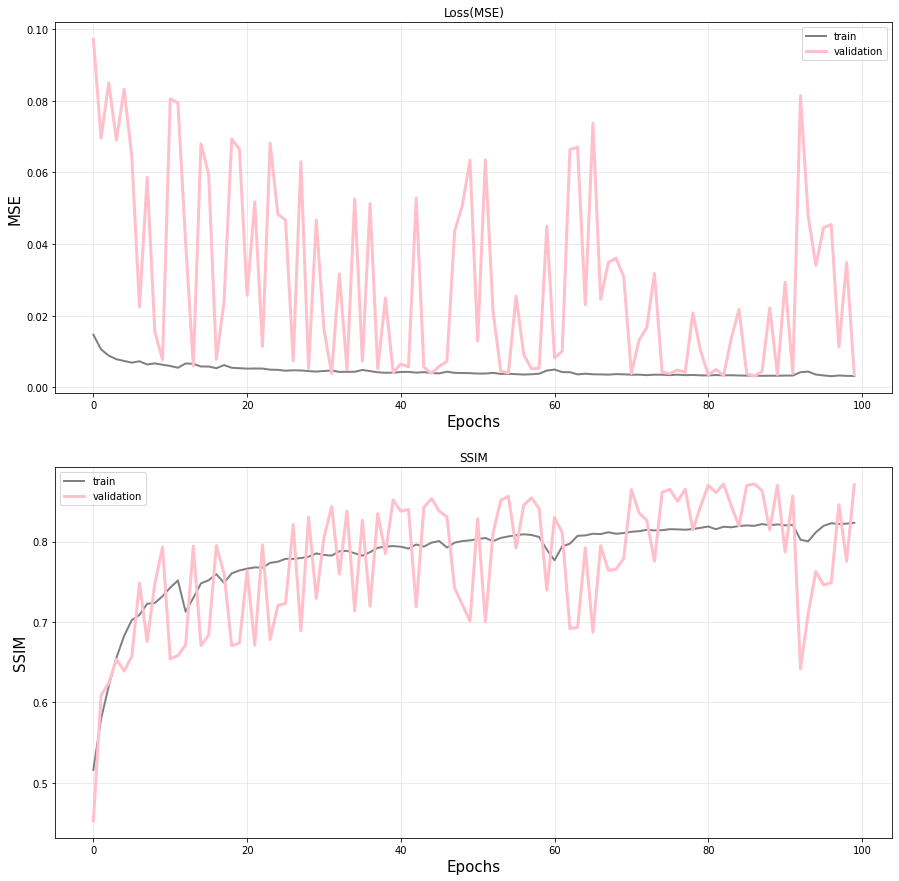

In [55]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history6_5_2.epoch, history6_5_2.history['loss'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_5_2.epoch, history6_5_2.history['val_loss'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('Loss(MSE)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(2,1,2)
plt.plot(history6_5_2.epoch, history6_5_2.history['SSIM'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_5_2.epoch, history6_5_2.history['val_SSIM'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('SSIM')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.grid(alpha=0.3)

plt.legend()

## model6_5_3(imageDenoise): RMSprop(learning_rate=0.001), batch size=32, epoch= 100


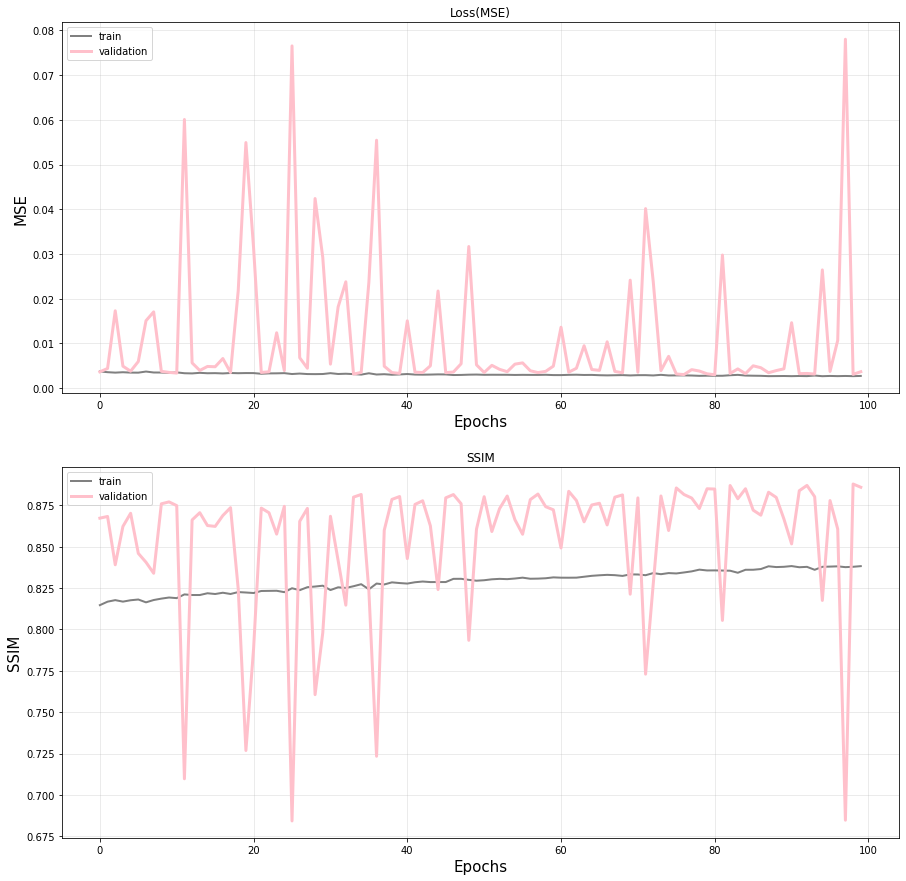

In [56]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(history6_5_3.epoch, history6_5_3.history['loss'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_5_3.epoch, history6_5_3.history['val_loss'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('Loss(MSE)')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(2,1,2)
plt.plot(history6_5_3.epoch, history6_5_3.history['SSIM'], label = 'train', color = 'gray', linewidth=2)
plt.plot(history6_5_3.epoch, history6_5_3.history['val_SSIM'], label = 'validation', color = 'pink', linewidth = 3)
plt.title('SSIM')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('SSIM', fontsize=15)
plt.grid(alpha=0.3)

plt.legend()

# validation 결과

## model6_3_1(Unet): SGD(learning_rate=0.01), batch size=32, epoch= 100

In [57]:
val_result6_3_1 = history6_3_1.model.evaluate(val_mask_image, val_image)

16/16 [==============================] - 1s 52ms/step - loss: 0.0033 - SSIM: 0.8948


## model6_3_2(Unet): Adam(learning_rate=0.001), batch size=32, epoch= 100

In [58]:
val_result6_3_2 = history6_3_2.model.evaluate(val_mask_image, val_image)

16/16 [==============================] - 1s 48ms/step - loss: 0.0033 - SSIM: 0.8948


## model6_3_3(Unet): RMSprop(learning_rate=0.001), batch size=32, epoch= 100

In [59]:
val_result6_3_3 = history6_3_3.model.evaluate(val_mask_image, val_image)

16/16 [==============================] - 1s 47ms/step - loss: 0.0033 - SSIM: 0.8948


## model6_5_1(imageDenoise): SGD(learning_rate=0.01), batch size=32, epoch= 100


In [60]:
val_result6_5_1 = history6_5_1.model.evaluate(val_mask_image, val_image)

16/16 [==============================] - 1s 79ms/step - loss: 0.0037 - SSIM: 0.8859


## model6_5_2(imageDenoise): Adam(learning_rate=0.001), batch size=32, epoch= 100


In [61]:
val_result6_5_2 = history6_5_2.model.evaluate(val_mask_image, val_image)

16/16 [==============================] - 1s 79ms/step - loss: 0.0037 - SSIM: 0.8859


## model6_5_3(imageDenoise): RMSprop(learning_rate=0.001), batch size=32, epoch= 100

In [62]:
val_result6_5_3 = history6_5_3.model.evaluate(val_mask_image, val_image)

16/16 [==============================] - 1s 80ms/step - loss: 0.0037 - SSIM: 0.8859


---
# *★★★validation 결과: model6_3_2 선정★★★*
---



# 선정된 모델(model6_3_2)의 test set에 대한 예측 결과 보기

test set에 data augmentation 실시

In [63]:
test = datagen.flow(test_mask_image, test_image)

## model6_3_2(Unet): Adam(learning_rate=0.001), batch size=32, epoch= 100

### 변형 안된 데이터들에 대한 예측 결과보기

흰 마스크

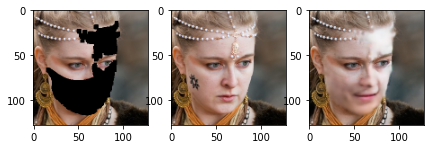

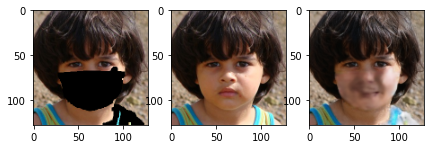

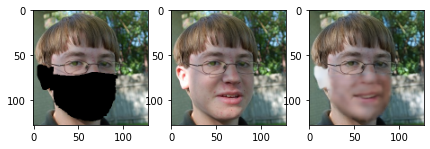

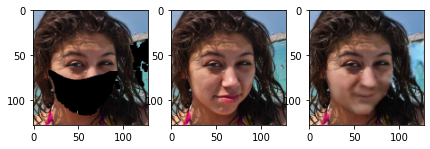

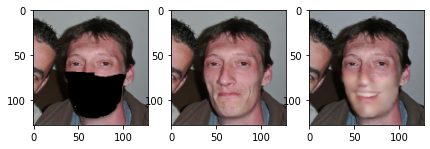

In [64]:
test_predict6_3_2 = model6_3_2.predict(test_mask_image)
plot_image_pair_test(test_predict6_3_2, 5,10)

파란 마스크

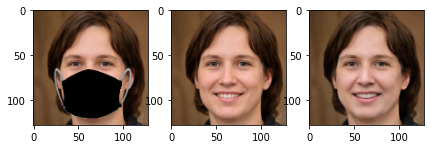

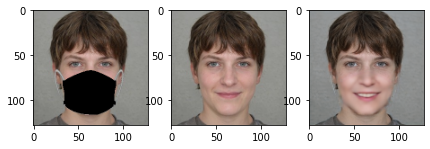

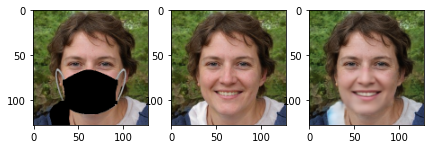

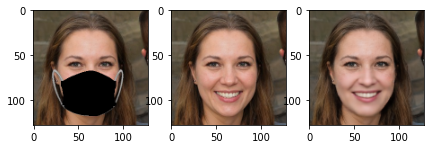

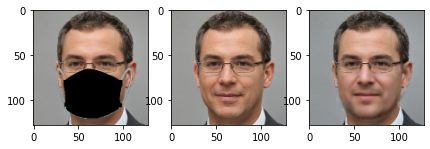

In [65]:
test_predict6_3_2 = model6_3_2.predict(test_mask_image)
plot_image_pair_test(test_predict6_3_2, 300, 305)

### 변형된 데이터에 대한 예측 결과 보기

흰 마스크

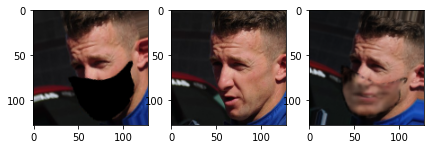

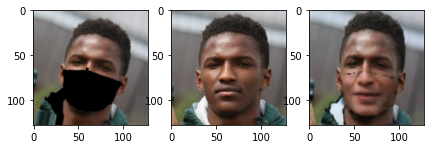

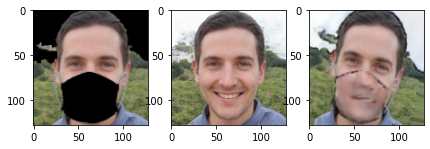

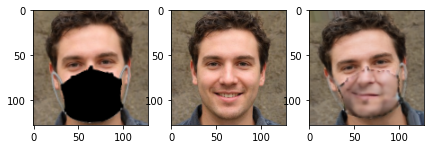

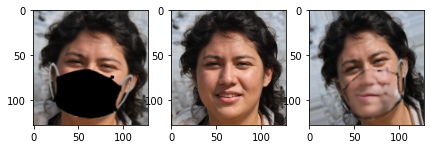

In [66]:
test_predict6_3_2= model6_3_2.predict(test[0][0])
for i in range(0,5):
    plt.figure(figsize = (7,7))
    plt.subplot(1,3,1)
    
    plt.imshow(test[0][0][i].reshape(SIZE, SIZE, 3))
    plt.subplot(1,3,2)
    
    plt.imshow(test[0][1][i].reshape(SIZE, SIZE, 3))
    plt.subplot(1,3,3)
    
    plt.imshow(test_predict6_3_2[i].reshape(SIZE,SIZE,3))

파란 마스크

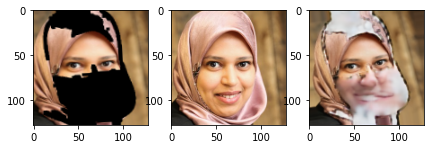

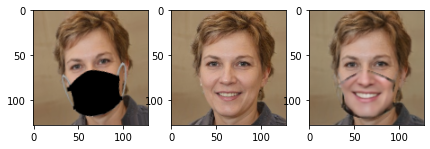

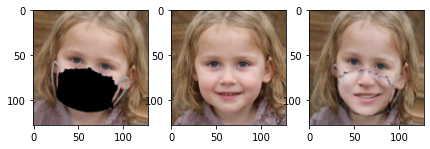

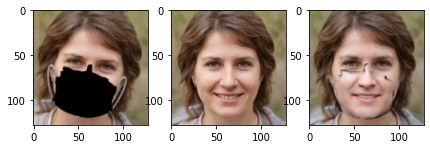

In [67]:
test_predict6_3_2 = model6_3_2.predict(test[0][0])
for i in range(16,20):
    plt.figure(figsize = (7,7))
    plt.subplot(1,3,1)
    
    plt.imshow(test[0][0][i].reshape(SIZE, SIZE, 3))
    plt.subplot(1,3,2)
    
    plt.imshow(test[0][1][i].reshape(SIZE, SIZE, 3))
    plt.subplot(1,3,3)
    
    plt.imshow(test_predict6_3_2[i].reshape(SIZE,SIZE,3))

# 최종 테스트 by 용명씨(선정 모델: model6_3_2)

model6_3_2: Adam(learning_rate=0.001), batch size=32, epoch= 100

In [68]:
import cv2
from PIL import Image

In [69]:
name = 'YM'
im = Image.open('/content/'+name+'.jpg')
imResize = im.resize((256,256), Image.ANTIALIAS)
imResize.save('/content/'+name+'_resized.jpg','JPEG',quality=90)

In [70]:
YM = cv2.imread('/content/YM_resized.jpg',1)
SIZE=128
preProcessImage(YM)
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)
YM = cv2.resize(YM, (SIZE, SIZE))
YM = YM.astype('float32') / 255.0
YM = YM.reshape(1,128,128,3)

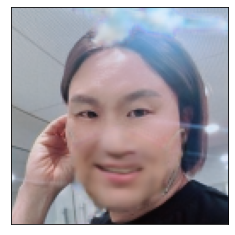

In [71]:
YM_predict = model6_3_2.predict(YM)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(YM_predict[0])